In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

In [3]:
BASE_DIR = "../../tests/sigma-over-underfit-test/"

# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

In [12]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

#profiles= ["sin2-3x512-s003", "sin2-3x512-s03", "sin2-3x512-s3", "sin2-3x512-sl"] 
profiles= ["tensin-3x512-s003", "tensin-3x512-s03", "tensin-3x512-s3", "tensin-3x512-sl"]

names = [configs[p]["NAME"] for p in profiles]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(profiles))]

reruns = 2

In [13]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x7f44abbc6760>)

In [14]:


train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    train_stats[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/train_stats_{run}.json", "r") as f:
            train_stats[name].append(json.load(f))

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    results[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/results_{run}.json", "r") as f:
            results[name].append(json.load(f))

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    posterior_samples[name] = []
    # Load posterior samples
    for run in range(1, reruns+1):
        train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_{run}.npy")
        test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_{run}.npy")
        test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_{run}.npy")
        test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_{run}.npy")

        posterior_samples[name].append({
            "train": train,
            "test": test,
            "test_in_domain": test_in_domain,
            "test_out_domain": test_out_domain
        })

In [31]:
train_stats["tensin-3x512-s3"][0]["val_rmse"][-1]

0.8463900685310364

In [33]:
results["tensin-3x512-s3"][0]["in_domain"]["error"]["rmse"]

0.8335061073303223

In [15]:
#Generate table for rmse
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "trmse-mean", "trmse-std", "irmse-mean", "irmse-std", "ormse-mean", "ormse-std"])

for p in profiles:
    name = configs[p]["NAME"]
    trmse_mean = np.mean([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    trmse_std = np.std([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    irmse_mean = np.mean([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    irmse_std = np.std([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    ormse = np.mean([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    ormse_std = np.std([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t.append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "trmse-mean": trmse_mean,
        "trmse-std": trmse_std,
        "irmse-mean": irmse_mean,
        "irmse-std": irmse_std,
        "ormse-mean": ormse,
        "ormse-std": ormse_std
    }, ignore_index=True)

#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])

round = 5
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["Train RMSE"] = temp_t["trmse-mean"].round(round).astype(str).add('±').add(temp_t["trmse-std"].multiply(2).round(round).astype(str))
    table["In domain RMSE"] = temp_t["irmse-mean"].round(round).astype(str).add('±').add(temp_t["irmse-std"].multiply(2).round(round).astype(str))
    table["Out domain RMSE"] = temp_t["ormse-mean"].round(round).astype(str).add('±').add(temp_t["ormse-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")

display(table)
print()

#Generate table for mae
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "trmae-mean", "trmae-std", "irmae-mean", "irmae-std", "ormae-mean", "ormae-std"])

for p in profiles:
    name = configs[p]["NAME"]
    trmae_mean = np.mean([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    trmae_std = np.std([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    irmae_mean = np.mean([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    irmae_std = np.std([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    ormae = np.mean([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    ormae_std = np.std([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t.append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "trmae-mean": trmae_mean,
        "trmae-std": trmae_std,
        "irmae-mean": irmae_mean,
        "irmae-std": irmae_std,
        "ormae-mean": ormae,
        "ormae-std": ormae_std
    }, ignore_index=True)

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["Train MAE"] = temp_t["trmae-mean"].round(round).astype(str).add('±').add(temp_t["trmae-std"].multiply(2).round(round).astype(str))
    table["In domain MAE"] = temp_t["irmae-mean"].round(round).astype(str).add('±').add(temp_t["irmae-std"].multiply(2).round(round).astype(str))
    table["Out domain MAE"] = temp_t["ormae-mean"].round(round).astype(str).add('±').add(temp_t["ormae-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")

display(table)

#Generate table for log likelihood
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "trll-mean", "trll-std", "irll-mean", "irll-std", "orll-mean", "orll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    trll_mean = np.mean([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    trll_std = np.std([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    irll_mean = np.mean([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    irll_std = np.std([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    orll = np.mean([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    orll_std = np.std([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t.append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "trll-mean": trll_mean,
        "trll-std": trll_std,
        "irll-mean": irll_mean,
        "irll-std": irll_std,
        "orll-mean": orll,
        "orll-std": orll_std
    }, ignore_index=True)

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train LL", "In domain LL", "Out domain LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["Train LL"] = temp_t["trll-mean"].round(round).astype(str).add('±').add(temp_t["trll-std"].multiply(2).round(round).astype(str))
    table["In domain LL"] = temp_t["irll-mean"].round(round).astype(str).add('±').add(temp_t["irll-std"].multiply(2).round(round).astype(str))
    table["Out domain LL"] = temp_t["orll-mean"].round(round).astype(str).add('±').add(temp_t["orll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")

display(table)


,Likelihood_std,Train RMSE,In domain RMSE,Out domain RMSE
Name,,,,
tensin-3x512-s003,0.03±0.0,0.14502±0.00051,8.80768±0.00738,31.93101±0.00644
tensin-3x512-s03,0.3±0.0,0.32309±0.00028,0.38872±2e-05,38.2797±0.00881
tensin-3x512-s3,3.0±0.0,0.8033±0.00019,0.83471±0.0024,24.85393±0.22941
tensin-3x512-sl,0.40518±0.09131,0.3873±0.00025,0.42588±2e-05,44.33263±0.02597


,Likelihood_std,Train MAE,In domain MAE,Out domain MAE
Name,,,,
tensin-3x512-s003,0.03±0.0,0.11±0.0,6.95±0.01,25.31±0.0
tensin-3x512-s03,0.3±0.0,0.26±0.0,0.31±0.0,32.47±0.0
tensin-3x512-s3,3.0±0.0,0.63±0.0,0.66±0.0,20.41±0.34
tensin-3x512-sl,0.41±0.09,0.31±0.0,0.34±0.0,37.39±0.02


,Likelihood_std,Train LL,In domain LL,Out domain LL
Name,,,,
tensin-3x512-s003,0.03±0.0,0.54±0.0,-1628.86±0.71,-2397.51±6.35
tensin-3x512-s03,0.3±0.0,-0.3±0.0,-0.5±0.0,-20.51±0.51
tensin-3x512-s3,3.0±0.0,-2.11±0.0,-2.11±0.0,-6.23±0.01
tensin-3x512-sl,0.41±0.09,-0.53±0.0,-0.59±0.0,-31.53±0.08


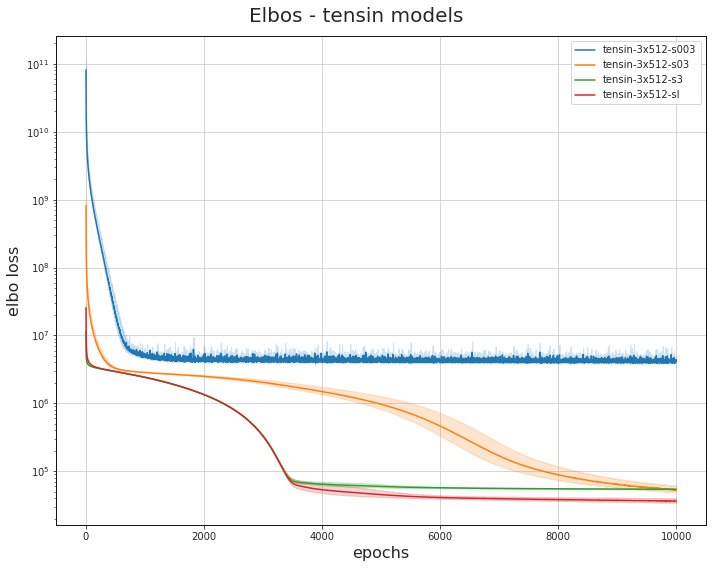

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Elbos - tensin models", fontsize=20)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = [train_stats[name][i]["elbos"] for i in range(reruns)]
    means = np.mean(elbos, axis=0)
    stds = np.std(elbos, axis=0)
    ax.plot(means, label=name, color=colors[i])

    #err_range = list(range(0, len(means), 1000))
    ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    #plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], alpha=0.5)
ax.set_yscale("log", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend()
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("elbo loss", fontsize=16)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg")
plt.show()

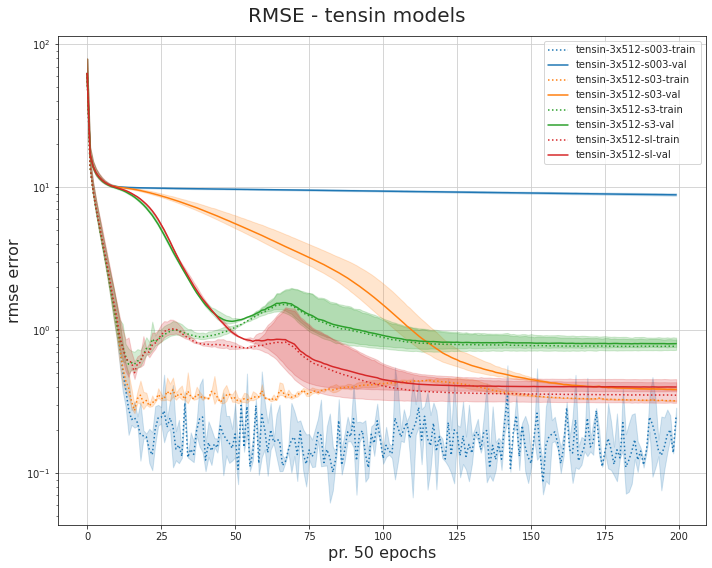

In [17]:
#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("RMSE - tensin models", fontsize=20)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_rmse"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.1, color=colors[i])
    #err_range = list(range(0, len(means), 10))
    ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    #plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], alpha=0.5)

    ve = [train_stats[name][i]["val_rmse"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i], hatch='//')
    #err_range = list(range(0, len(means), 10))
    ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    #plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], alpha=0.5)
    ax.set_yscale('log')
ax.legend()
ax.set_xlabel("pr. 50 epochs", fontsize=16)
ax.set_ylabel("rmse error", fontsize=16)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse.svg", format="svg")
plt.show()

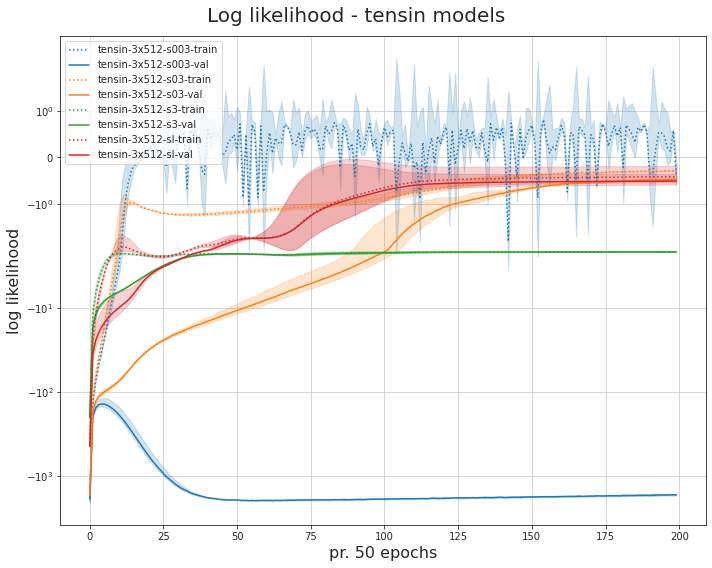

In [18]:
#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Log likelihood - tensin models", fontsize=20)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_ll"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])

    ve = [train_stats[name][i]["val_ll"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
ax.legend()
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=16)
ax.set_ylabel("log likelihood", fontsize=16)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll.svg", format="svg")
plt.show()

In [11]:
train_rmse = [results[k]["train"]["error"]["rmse"] for k in names]
in_domain_rmse = [results[k]["in_domain"]["error"]["rmse"] for k in names]
out_domain_rmse = [results[k]["out_domain"]["error"]["rmse"] for k in names]

metrics = [("train_rmse", train_rmse), ("in_domain_rmse", in_domain_rmse), ("out_domain_rmse", out_domain_rmse)]



fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    #annotate each point
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("RMSE")
    ax[i].set_ylim(bottom=0.0)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)
    ax[i].grid(False)

plt.show()



train_mae = [results[k]["train"]["error"]["mae"] for k in names]
in_domain_mae = [results[k]["in_domain"]["error"]["mae"] for k in names]
out_domain_mae = [results[k]["out_domain"]["error"]["mae"] for k in names]

metrics = [("train_mae", train_mae), ("in_domain_mae", in_domain_mae), ("out_domain_mae", out_domain_mae)]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("MAE")
    ax[i].set_ylim(bottom=0.0)
    #set x labels to be slanted
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)

plt.show()

TypeError: list indices must be integers or slices, not str

In [ ]:
run = 1

name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [ ]:
data_samples

{'train_x': array([[-1.6760066 ,  0.13096029,  0.90822107, ...,  0.12850094,
         -0.16505106,  0.44096446],
        [-0.42253196,  1.0120101 , -1.3815567 , ...,  0.36119458,
          0.6858255 ,  0.39450464],
        [ 0.48549464, -1.645571  , -0.7874351 , ...,  1.2767967 ,
         -1.6509557 ,  0.25202864],
        ...,
        [ 0.42145473, -0.9169841 , -1.4460163 , ..., -0.49969822,
         -1.6692524 ,  0.5906019 ],
        [ 1.8919731 , -0.96714973, -1.5621512 , ...,  1.5890294 ,
          1.068533  ,  0.2827154 ],
        [ 1.2579542 , -1.7314732 ,  1.7899853 , ..., -0.06066706,
          0.05272781, -0.8387239 ]], dtype=float32),
 'test_in_domain_x': array([[-1.8296361 , -1.0823725 ,  0.85123086, ...,  1.8528578 ,
          1.3864892 ,  1.4943315 ],
        [ 0.4339023 , -1.6053351 ,  1.1313593 , ..., -1.1239201 ,
         -0.2161053 ,  0.40231904],
        [-0.9201559 ,  1.302833  ,  0.02482753, ...,  1.0739338 ,
         -1.4666815 , -1.713265  ],
        ...,
        

In [ ]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1][0]["train"].shape)

(1000, 10)
(1000, 1000)
(1000, 1000)


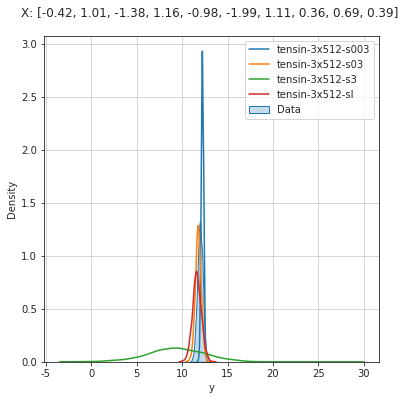

In [ ]:
# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p][run-1]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

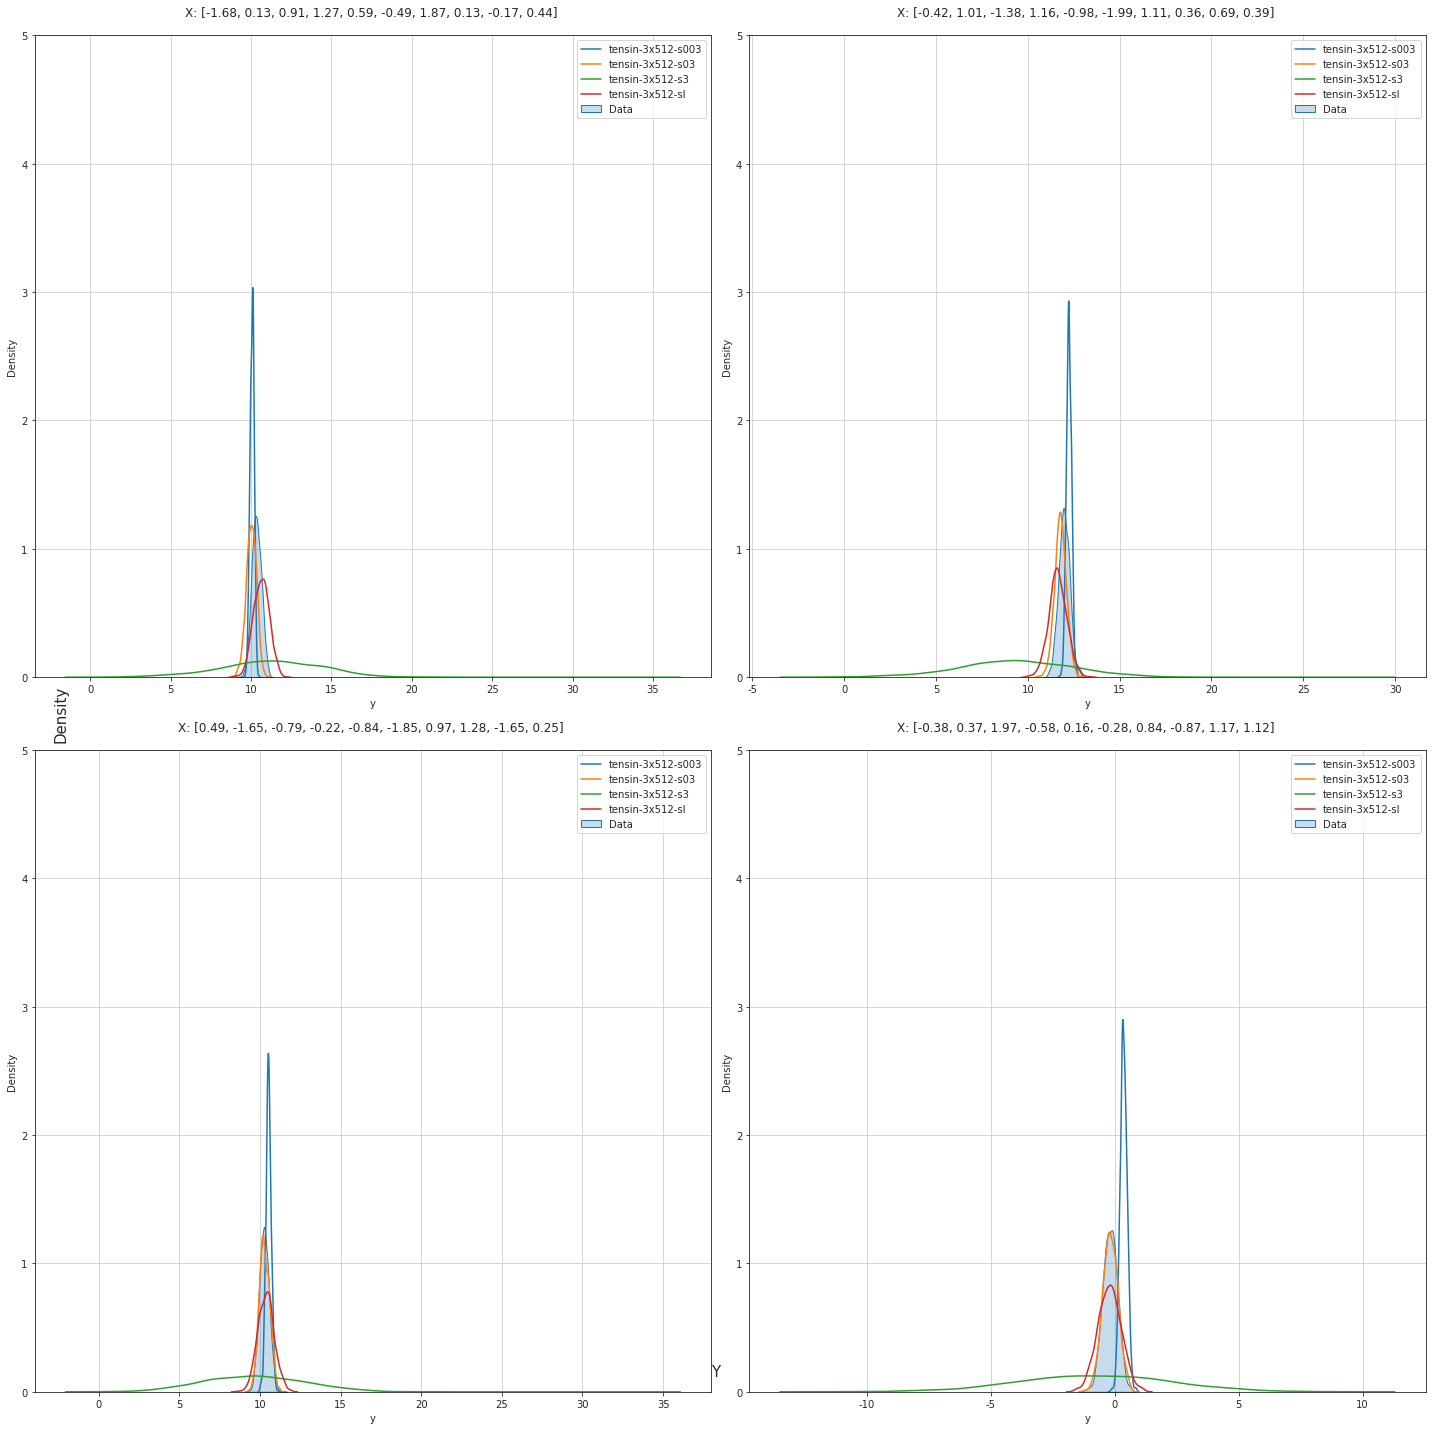

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.tight_layout()

plt.show()